# Analysis and Results
the following code contains the data proccecing and analysis of our project. 

## imports

In [74]:
!pip install causalml

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [75]:
import causalml
from causalml import propensity, inference
from causalml.inference import meta

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
import warnings

from causalml.inference.meta import LRSRegressor
from causalml.inference.meta import XGBTRegressor, MLPTRegressor
from causalml.inference.meta import BaseXRegressor, BaseRRegressor, BaseSRegressor, BaseTRegressor
from causalml.match import NearestNeighborMatch, MatchOptimizer, create_table_one
from causalml.propensity import ElasticNetPropensityModel
from causalml.dataset import *
from causalml.metrics import *

from causalml.inference.meta import LRSRegressor
from sklearn.model_selection import KFold

import matplotlib.pyplot as plt
import pandas as pd

warnings.filterwarnings('ignore')
plt.style.use('fivethirtyeight')

%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Utility functions


In [76]:
# loading the required dataset and pre-process it.

def df_to_return(name_of_date, subj='math'):
  if name_of_date == 'merged':
    # prepocess
    df = pd.read_csv('merged.csv')
    same_for_both = ['activities', 'higher', 'famrel', 'freetime',  'goout', 'Dalc', 'Walc', 'health', 'guardian', 'traveltime', 'romantic']

    # remove students (integrity)
    indexes = [79, 80, 122, 123, 323, 111, 112, 280, 281, 289, 378, 244]

    df = df.drop(indexes)
    df = df.reset_index()
    df['index'] = df.index

    to_remove = '_math' if subj=='por' else '_por'

    for col in same_for_both:
      df[col] = df[col + '_' + subj]
      df.drop([col + '_' + subj, col  + to_remove], axis=1, inplace=True)

    df['famsup' + '_por'] = df['famsup' + '_por'].map({'yes': 1, 'no': 0})
    df['schoolsup' + '_por'] = df['schoolsup' + '_por'].map({'yes': 1, 'no': 0})
    df['paid' + '_por'] = df['paid' + '_por'].map({'yes': 1, 'no': 0})

    df['famsup' + '_math'] = df['famsup' + '_math'].map({'yes': 1, 'no': 0})
    df['schoolsup' + '_math'] = df['schoolsup' + '_math'].map({'yes': 1, 'no': 0})
    df['paid' + '_math'] = df['paid' + '_math'].map({'yes': 1, 'no': 0})

    col_remove = set([col if to_remove in col else 'remove' for col in df.columns])
    col_remove.remove('remove')

    subj_df = df.drop(col_remove, axis=1)

    treatment = subj_df['famsup_'+ subj] 
    subj_df = subj_df.drop(['famsup_'+ subj], axis=1)

    cols = ["school", 'sex', 'address',
            'famsize', 'Pstatus',
            'Mjob', 'Fjob', 'reason', 'guardian',
            'activities', 'nursery',
            'higher', 'internet', 'romantic']
            #'Medu', 'Fedu', 'traveltime']
            #'studytime_' + subj, 'failures_' + subj, 'famrel', 'freetime', 'goout', 'health', 'Dalc', 'Walc']

    X_encoded = pd.get_dummies(subj_df, columns=cols, drop_first=True)

    avrg = 11
    y = X_encoded['G3_' + subj] #.map(lambda x: x>=avrg).map({False: 0, True: 1})
    X_encoded.drop(['index', 'G3_' + subj], axis=1, inplace=True)

    return X_encoded, treatment, y

  else:
    # full math/por csv
    math_df = pd.read_csv('student-' + name_of_date + '.csv')

    math_df['famsup'] = math_df['famsup'].map({'yes': 1, 'no': 0})
    math_df['schoolsup'] = math_df['schoolsup'].map({'yes': 1, 'no': 0})
    math_df['paid'] = math_df['paid'].map({'yes': 1, 'no': 0})


    treatment = math_df['famsup'] 
    subj_df = math_df.drop(['famsup'], axis=1)

    cols = ["school", 'sex', 'address',
            'famsize', 'Pstatus',
            'Mjob', 'Fjob', 'reason', 'guardian',
            'activities', 'nursery',
            'higher', 'internet', 'romantic']
            #'Medu', 'Fedu', 'traveltime']
            #'studytime_' + subj, 'failures_' + subj, 'famrel', 'freetime', 'goout', 'health', 'Dalc', 'Walc']

    X_encoded = pd.get_dummies(subj_df, columns=cols, drop_first=True)

    avrg = 11
    y = X_encoded['G3'].map(lambda x: x>=avrg).map({False: 0, True: 1})
    X_encoded.drop(['G3'], axis=1, inplace=True)

    return X_encoded, treatment, y

In [77]:
def k_fold(X_encoded, y, treatment):
  def learner(regressor, X, treatment, y):
      try:
        ate_s = regressor.estimate_ate(X=X, treatment=treatment, y=y)
        return [ate_s[0][0], ate_s[1][0], ate_s[2][0]]  # ate, lb, ub 
      
      except:
        ate_s = regressor.estimate_ate(X=X, treatment=treatment, y=y, return_ci=True)
        return [ate_s[0][0], ate_s[1][0], ate_s[2][0]]  # ate, lb, ub 

  

  results = pd.DataFrame(columns=['fold', 'method', 'regressor', 'type', 'cate', 'lb', 'ub'])

  kf = KFold(n_splits=5)
  k = 1
  for train_index, val_index in kf.split(X_encoded):
      X_train, X_val = X_encoded.iloc[train_index], X_encoded.iloc[val_index]
      y_train, y_val = y[train_index], y[val_index]
      treatment_train, treatment_val = treatment[train_index], treatment[val_index]

      # s_learner
      results.loc[len(results.index)] = [k, 's_learner', 'LR', 'train'] + learner(LRSRegressor(), X_train, treatment_train, y_train)
      results.loc[len(results.index)] = [k, 's_learner', 'LR', 'val'] + learner(LRSRegressor(), X_val, treatment_val, y_val)

      results.loc[len(results.index)] = [k, 's_learner', 'LGBM', 'train'] + learner(BaseSRegressor(learner=LGBMRegressor()), X_train, treatment_train, y_train)
      results.loc[len(results.index)] = [k, 's_learner', 'LGBM', 'val'] + learner(BaseSRegressor(learner=LGBMRegressor()), X_val, treatment_val, y_val)

      results.loc[len(results.index)] = [k, 's_learner', 'XGBT', 'train'] + learner(BaseSRegressor(learner=XGBRegressor()), X_train, treatment_train, y_train)
      results.loc[len(results.index)] = [k, 's_learner', 'XGBT', 'val'] + learner(BaseSRegressor(learner=XGBRegressor()), X_val, treatment_val, y_val)

      # t_learner
      results.loc[len(results.index)] = [k, 't_learner', 'LGBM', 'train'] + learner(BaseTRegressor(learner=LGBMRegressor()), X_train, treatment_train, y_train)
      results.loc[len(results.index)] = [k, 't_learner', 'LGBM', 'val'] + learner(BaseTRegressor(learner=LGBMRegressor()), X_val, treatment_val, y_val)

      results.loc[len(results.index)] = [k, 't_learner', 'XGBT', 'train'] + learner(XGBTRegressor(), X_train, treatment_train, y_train)
      results.loc[len(results.index)] = [k, 't_learner', 'XGBT', 'val'] + learner(XGBTRegressor(), X_val, treatment_val, y_val)

      results.loc[len(results.index)] = [k, 't_learner', 'LR', 'train'] + learner(BaseTRegressor(learner=LinearRegression()), X_train, treatment_train, y_train)
      results.loc[len(results.index)] = [k, 't_learner', 'LR', 'val'] + learner(BaseTRegressor(learner=LinearRegression()), X_val, treatment_val, y_val)

      k += 1
  
  return results

In [78]:
# visualize the result

def visualize_CI(results):
  x_train = results[results['type'] == 'train'].groupby(['method', 'regressor', 'type']).mean()
  x_val = results[results['type'] == 'val'].groupby(['method', 'regressor', 'type']).mean()

  cate_train = x_train.cate
  lb_train = x_train.lb

  errors_train = cate_train - lb_train


  cate_val = x_val.cate
  lb_val = x_val.lb

  errors_val = cate_val - lb_val


  y_train = [1, 4, 7, 10, 13, 16]
  y_val = [2, 5, 8, 11, 14, 17]

  plt.figure()
  plt.errorbar(cate_train, y_train, xerr=errors_train, fmt = 'o', color = 'b')
  plt.errorbar(cate_val, y_val, xerr=errors_val, fmt = 'o', color = 'r')
  plt.yticks((0, 1.5, 4.5, 7.5, 10.5, 13.5, 16.5, 18), ('', 's_learner LGBM',  's_learner LR', 's_learner XGB', 't_learner LGBM', 't_learner LR', 't_learner XGB' ,''))

  plt.legend(['train', 'val'])

In [79]:
def CATE_on_full_df(X_encoded, treatment, y):
  def learner(regressor, X, treatment, y):
    ate_s = regressor.estimate_ate(X=X, treatment=treatment, y=y)
    return [ate_s[0][0], ate_s[1][0], ate_s[2][0]]  # ate, lb, ub 


  t_xgb = learner(XGBTRegressor(),X_encoded, treatment, y)[0]


  def learner(regressor, X, treatment, y):
    ate_s = regressor.estimate_ate(X=X, treatment=treatment, y=y)
    return [ate_s[0][0], ate_s[1][0], ate_s[2][0]]  # ate, lb, ub 


  t_lr = learner(BaseTRegressor(learner=LinearRegression()),X_encoded, treatment, y)[0]


  def learner(regressor, X, treatment, y):
      ate_s = regressor.estimate_ate(X=X, treatment=treatment, y=y) #, return_ci=True)
      return [ate_s[0][0], ate_s[1][0], ate_s[2][0]]  # ate, lb, ub  


  t_LGBM = learner(BaseTRegressor(learner=LGBMRegressor()),X_encoded, treatment, y)[0]


  # s learner
  def learner(regressor, X, treatment, y):
    ate_s = regressor.estimate_ate(X=X, treatment=treatment, y=y)
    return [ate_s[0][0], ate_s[1][0], ate_s[2][0]]  # ate, lb, ub 


  s_lr = learner(LRSRegressor(),X_encoded, treatment, y)[0]

  def learner(regressor, X, treatment, y):
      ate_s = regressor.estimate_ate(X=X, treatment=treatment, y=y, return_ci=True)
      return [ate_s[0][0], ate_s[1][0], ate_s[2][0]]  # ate, lb, ub 

  s_LGBM = learner(BaseSRegressor(learner=LGBMRegressor()), X_encoded, treatment, y)[0]


  def learner(regressor, X, treatment, y):
    try:
      ate_s = regressor.estimate_ate(X=X, treatment=treatment, y=y)
      return [ate_s[0][0], ate_s[1][0], ate_s[2][0]]  # ate, lb, ub 
    
    except:
      ate_s = regressor.estimate_ate(X=X, treatment=treatment, y=y, return_ci=True)
      return [ate_s[0][0], ate_s[1][0], ate_s[2][0]]  # ate, lb, ub 


  s_xgb = learner(BaseSRegressor(learner=XGBRegressor()),X_encoded, treatment, y)[0]


  final = pd.DataFrame(columns=['Method', 'Regressor', 'CATE'])
  final.loc[len(final.index)] = ['s_learner', 'LR', s_lr]
  final.loc[len(final.index)] = ['s_learner', 'LGBM', s_LGBM]
  final.loc[len(final.index)] = ['s_learner', 'XGB', s_xgb]
  final.loc[len(final.index)] = ['t_learner', 'LR', t_lr]
  final.loc[len(final.index)] = ['t_learner', 'LGBM', t_LGBM]
  final.loc[len(final.index)] = ['t_learner', 'XGB', t_xgb]

  return final

# Analysis of student-mat.csv

computing the CATE for all the students in math class, 395 records 

In [80]:
X_encoded, treatment, y = df_to_return('mat') # full math csv

preforming 5 fold cross validation using diffrent methods and saving the results into df.  

In [81]:
results = k_fold(X_encoded, y, treatment)
results.groupby(['method', 'regressor', 'type']).mean() # showing the average cate including CI for each method

[20:18:25] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:18:25] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:18:25] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:18:25] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:18:25] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:18:25] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:18:25] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:18:26] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

cate        lb        ub
method    regressor type                               
s_learner LGBM      train  0.018101 -0.002344  0.038545
                    val    0.002138 -0.065278  0.069554
          LR        train  0.024770 -0.057778  0.107318
                    val    0.032904 -0.166553  0.232362
          XGBT      train  0.013185 -0.009136  0.035507
                    val    0.003835 -0.007352  0.015022
t_learner LGBM      train  0.016914 -0.016222  0.050050
                    val   -0.018509 -0.234739  0.197721
          LR        train  0.018591 -0.045086  0.082268
                    val   -0.141832 -0.598206  0.314542
          XGBT      train  0.022891 -0.006737  0.052519
                    val    0.029462 -0.036614  0.095537

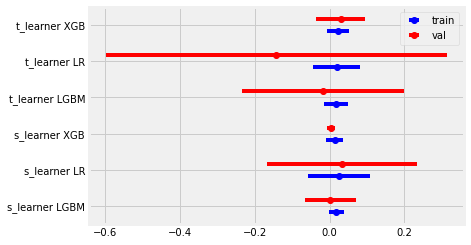

In [82]:
# visualize the result
visualize_CI(results)

computing CATE for the full dataset

In [83]:
final = CATE_on_full_df(X_encoded, treatment, y)
final.groupby(['Method',	'Regressor']).mean()

[20:18:29] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:18:29] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:18:29] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:18:29] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


CATE
Method    Regressor          
s_learner LGBM       0.023249
          LR         0.025706
          XGB        0.013689
t_learner LGBM       0.020552
          LR         0.016386
          XGB        0.023446

# Analysis of student-por.csv

computing the CATE for all the students in Portuguese class, 649 records 

In [84]:
X_encoded, treatment, y = df_to_return('por') # full por csv

preforming 5 fold cross validation using diffrent methods and saving the results into df. 

In [85]:
results = k_fold(X_encoded, y, treatment)
results.groupby(['method', 'regressor', 'type']).mean() # showing the average cate including CI for each method

[20:18:30] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:18:30] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:18:30] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:18:30] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:18:30] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:18:31] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:18:31] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:18:31] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

cate        lb        ub
method    regressor type                               
s_learner LGBM      train -0.001736 -0.021082  0.017610
                    val   -0.004768 -0.059601  0.050065
          LR        train -0.004109 -0.065240  0.057022
                    val   -0.015944 -0.148895  0.117007
          XGBT      train -0.001557 -0.030706  0.027592
                    val   -0.021324 -0.043519  0.000870
t_learner LGBM      train -0.008696 -0.036642  0.019249
                    val    0.023687 -0.076212  0.123585
          LR        train -0.004705 -0.058659  0.049248
                    val   -0.027586 -0.202023  0.146851
          XGBT      train -0.009089 -0.035480  0.017302
                    val   -0.016049 -0.067777  0.035678

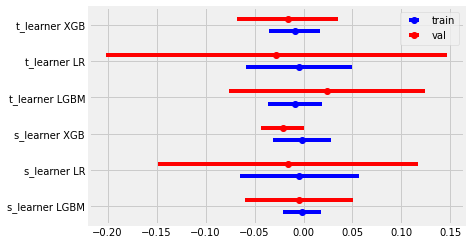

In [86]:
# visualize the result
visualize_CI(results)

computing CATE for the full dataset

In [87]:
final = CATE_on_full_df(X_encoded, treatment, y)
final.groupby(['Method',	'Regressor']).mean()

[20:18:34] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:18:34] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:18:34] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:18:34] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


CATE
Method    Regressor          
s_learner LGBM      -0.004355
          LR        -0.003940
          XGB       -0.002112
t_learner LGBM      -0.012748
          LR        -0.001740
          XGB       -0.002307

# Analysis of merged.csv on math subject

computing the CATE for all the students in math class, 370 records 

In [88]:
X_encoded, treatment, y = df_to_return('merged',subj='math') # merged math

preforming 5 fold cross validation using diffrent methods and saving the results into df. 

In [89]:
results = k_fold(X_encoded, y, treatment)
results.groupby(['method', 'regressor', 'type']).mean() # showing the average cate including CI for each method

[20:18:35] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:18:35] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:18:35] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:18:35] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:18:35] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:18:35] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:18:35] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:18:35] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

cate        lb        ub
method    regressor type                               
s_learner LGBM      train -0.048959 -0.211706  0.113788
                    val   -0.009576 -0.756318  0.737166
          LR        train  0.184858 -0.333017  0.702734
                    val   -0.088570 -1.538039  1.360899
          XGBT      train -0.016484 -0.197215  0.164247
                    val   -0.005159 -0.113130  0.102812
t_learner LGBM      train -0.075507 -0.399578  0.248565
                    val   -0.490129 -2.477400  1.497142
          LR        train  0.320327 -0.091389  0.732042
                    val   -0.683036 -2.127348  0.761276
          XGBT      train -0.064530 -0.264763  0.135704
                    val   -0.033160 -0.621944  0.555623

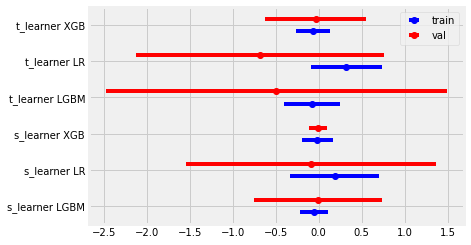

In [90]:
# visualize the result
visualize_CI(results)

computing CATE for the full dataset

In [91]:
final = CATE_on_full_df(X_encoded, treatment, y)
final.groupby(['Method',	'Regressor']).mean()

[20:18:40] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:18:40] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:18:41] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:18:41] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


CATE
Method    Regressor          
s_learner LGBM      -0.057827
          LR         0.201594
          XGB       -0.046224
t_learner LGBM      -0.138324
          LR         0.325676
          XGB       -0.122709

# Analysis of merged.csv on Portuguese subject

computing the CATE for all the students in math class, 370 records 

In [92]:
X_encoded, treatment, y = df_to_return('merged', subj='por') # mearged por

preforming 5 fold cross validation using diffrent methods and saving the results into df. 

In [93]:
results = k_fold(X_encoded, y, treatment)
results.groupby(['method', 'regressor', 'type']).mean() # showing the average cate including CI for each method

[20:18:42] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:18:42] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:18:42] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:18:42] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:18:42] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:18:42] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:18:43] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:18:43] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

cate        lb        ub
method    regressor type                               
s_learner LGBM      train  0.015661 -0.178828  0.210150
                    val    0.105776 -0.482747  0.694299
          LR        train  0.053218 -0.241950  0.348387
                    val    0.064653 -0.641993  0.771298
          XGBT      train  0.009023 -0.128007  0.146052
                    val    0.000259 -0.102506  0.103024
t_learner LGBM      train  0.110744 -0.163479  0.384967
                    val    0.558516 -0.749291  1.866323
          LR        train  0.017027 -0.286383  0.320438
                    val    0.142760 -0.739807  1.025328
          XGBT      train  0.168203 -0.006996  0.343403
                    val    0.387863  0.016638  0.759088

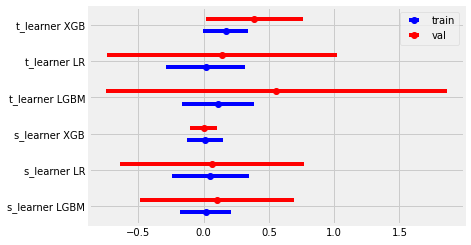

In [94]:
# visualize the result
visualize_CI(results)

computing CATE for the full dataset

In [95]:
final = CATE_on_full_df(X_encoded, treatment, y)
final.groupby(['Method',	'Regressor']).mean()

[20:18:47] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:18:47] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:18:48] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:18:48] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


CATE
Method    Regressor          
s_learner LGBM       0.006423
          LR         0.051487
          XGB        0.001051
t_learner LGBM       0.092763
          LR         0.001366
          XGB        0.159498

# Feature importance analysis

## imports and utility functions

In [111]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

from causalml.inference.meta import BaseSRegressor, BaseTRegressor, BaseXRegressor, BaseRRegressor
from causalml.inference.tree import UpliftTreeClassifier, UpliftRandomForestClassifier
from causalml.dataset.regression import synthetic_data
from sklearn.linear_model import LinearRegression

import shap
import matplotlib.pyplot as plt

import time
from sklearn.inspection import permutation_importance
from sklearn.model_selection import train_test_split

import os
import warnings
warnings.filterwarnings('ignore')

os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'  # for lightgbm to work

%reload_ext autoreload
%autoreload 2
%matplotlib inline
plt.style.use('fivethirtyeight')

In [112]:
def s_learner_shaply(X_encoded, treatment, y):
  w_multi = np.array(['treatment' if x==1 else 'control' for x in treatment])
  X = X_encoded
  feature_names =  list(X.columns) # specify feature names
  model_tau = LGBMRegressor(importance_type='gain')  # specify model for model_tau

  slearner = BaseSRegressor(XGBRegressor(), control_name='control')
  slearner.estimate_ate(X, w_multi, y)
  slearner_tau = slearner.fit_predict(X, w_multi, y)
  shap_slearner = slearner.get_shap_values(X=X, tau=slearner_tau)
  slearner.plot_shap_values(X=X, tau=slearner_tau, features=feature_names)

In [113]:
def t_learner_shaply(X_encoded, treatment, y):
  w_multi = np.array(['treatment' if x==1 else 'control' for x in treatment])
  X = X_encoded
  feature_names =  list(X.columns) # specify feature names
  model_tau = LGBMRegressor(importance_type='gain')  # specify model for model_tau

  tlearner = BaseTRegressor(XGBRegressor(), control_name='control')
  tlearner.estimate_ate(X, w_multi, y)
  tlearner_tau = tlearner.fit_predict(X, w_multi, y)
  shap_tlearner = tlearner.get_shap_values(X=X, tau=tlearner_tau)
  tlearner.plot_shap_values(X=X, tau=tlearner_tau, features=feature_names)

## analysis

[20:37:56] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:37:56] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


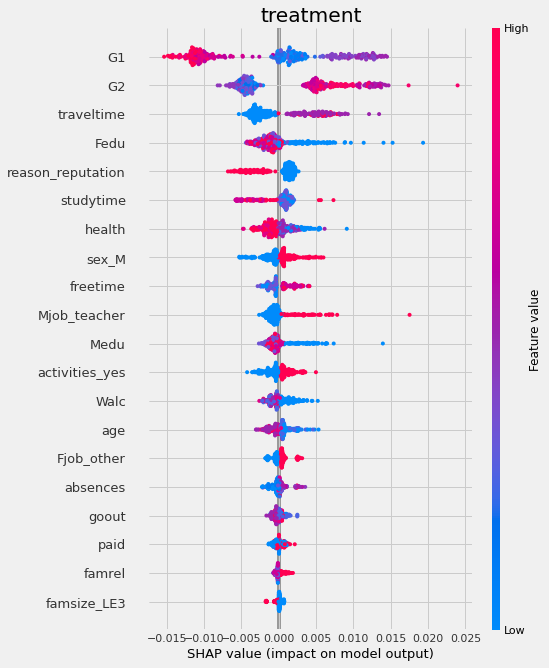

In [114]:
# student-mat.csv : all math student (395)
X_encoded, treatment, y = df_to_return('mat') # full math csv
s_learner_shaply(X_encoded, treatment, y)

[20:37:59] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:37:59] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:37:59] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:37:59] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


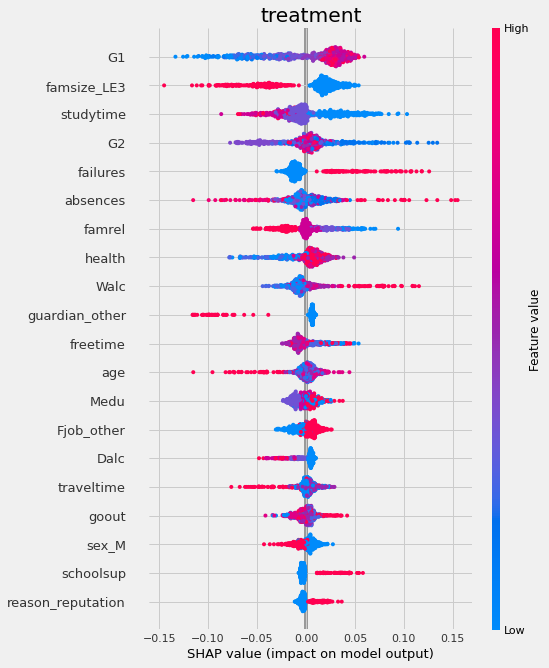

In [115]:
# student-por.csv : all Portuguese student (649)
X_encoded, treatment, y = df_to_return('por') # full math csv
t_learner_shaply(X_encoded, treatment, y)

[20:38:55] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:38:55] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:38:55] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:38:55] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


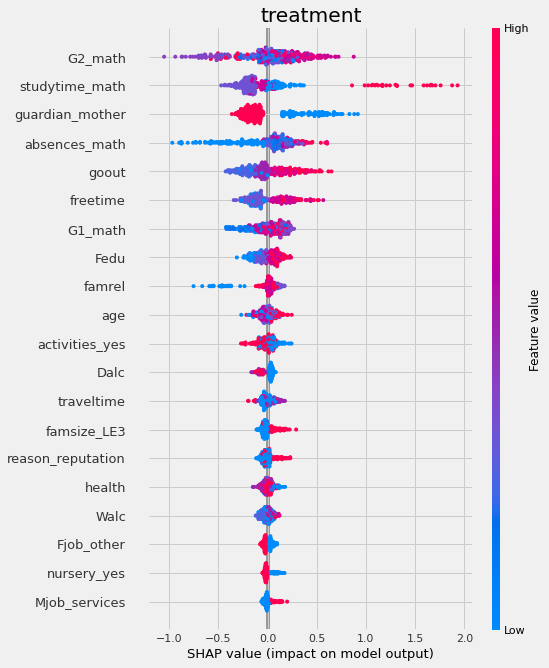

In [120]:
# merged.csv - on math class (370)
X_encoded, treatment, y = df_to_return('merged',subj='math') # merged math
t_learner_shaply(X_encoded, treatment, y)

[20:39:39] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:39:39] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:39:39] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:39:39] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


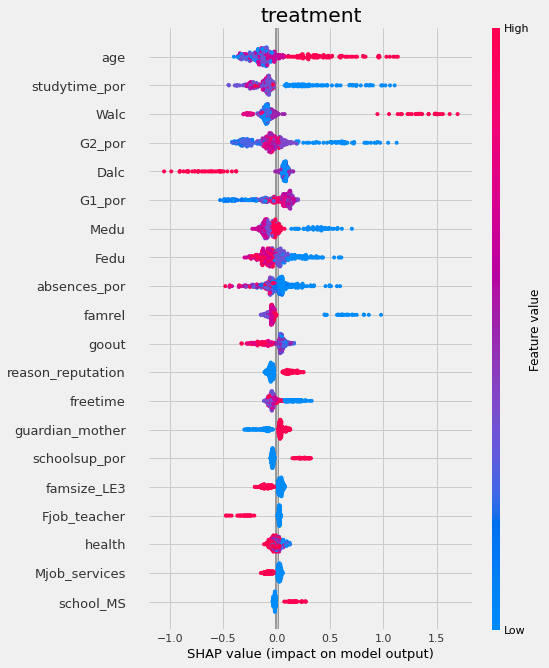

In [122]:
# merged.csv - on math class (370)
X_encoded, treatment, y = df_to_return('merged', subj='por') # mearged por
t_learner_shaply(X_encoded, treatment, y)